In [15]:
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt
import msvcrt
import pickle
import itertools

class Program:
    def __init__(self, code):
        self.pos = 0 # position pointer
        self.code = defaultdict(lambda:0)
        for i,v in enumerate(code):
            self.code[i] = v
        self.rel = 0 # offset value for relative mode
        self.inputs = []
        
    def add_inputs(self,inputs):
        for i in inputs:
            self.inputs.insert(0,i)
    
    def _parse_opcode(self, opcode):
        """
        Parse an opcode, getting the parameter modes and instruction.
        Opcode should be input as integer.
        """
        code = str(opcode)
        l = len(code)
        inst = int(code[-2:])
        modes = []
        for i in range(l-2):
            modes.append(int(code[l-3-i]))
        return inst, modes
    
    def _get_val_idx(self,loc,mode):
        if mode==0: # position mode
            return self.code[loc]
        elif mode==1: # immediate mode
            return loc
        elif mode==2: # relative mode
            return self.rel+self.code[loc]
        
    def _step(self):
        """
        Exit codes: 
           0 : continue execution
           1 : program finished
           2 : waiting for input
        """
        output = None
        exit_code = 0
        pos = self.pos # where are we in the code

        inst, modes = self._parse_opcode(self.code[pos])
        if inst == 99: # terminate
            exit_code = 1
            
        if inst == 1: # add
            modes = modes+(3-len(modes))*[0]
            v1 = self.code[self._get_val_idx(pos+1,modes[0])]
            v2 = self.code[self._get_val_idx(pos+2,modes[1])]
            self.code[self._get_val_idx(pos+3,modes[2])] = v1+v2 
            pos += 4
            
        if inst == 2: # multiply
            modes = modes+(3-len(modes))*[0]
            v1 = self.code[self._get_val_idx(pos+1,modes[0])]
            v2 = self.code[self._get_val_idx(pos+2,modes[1])]
            self.code[self._get_val_idx(pos+3,modes[2])] = v1*v2 
            pos += 4
            
        if inst == 3: # store input
            try:
                modes = modes + (1-len(modes))*[0]
                self.code[self._get_val_idx(pos+1,modes[0])] = self.inputs.pop()
                pos += 2
            except IndexError: # must wait for additional input
                exit_code = 2
                
        if inst == 4: # output value
            modes = modes+(1-len(modes))*[0]
            v = self.code[self._get_val_idx(pos+1,modes[0])]
            output = v
            pos += 2
            
        if inst == 5: # jump-if-true
            modes = modes+(2-len(modes))*[0]
            v1 = self.code[self._get_val_idx(pos+1,modes[0])]
            v2 = self.code[self._get_val_idx(pos+2,modes[1])]
            if v1 > 0:
                pos = v2
            else:
                pos += 3
                
        if inst == 6: # jump-if-false
            modes = modes+(2-len(modes))*[0]
            v1 = self.code[self._get_val_idx(pos+1,modes[0])]
            v2 = self.code[self._get_val_idx(pos+2,modes[1])]
            if v1 == 0:
                pos = v2
            else:
                pos += 3
                
        if inst == 7:
            modes = modes+(3-len(modes))*[0]
            v1 = self.code[self._get_val_idx(pos+1,modes[0])]
            v2 = self.code[self._get_val_idx(pos+2,modes[1])]
            if v1 < v2:
                self.code[self._get_val_idx(pos+3,modes[2])] = 1
            else:
                self.code[self._get_val_idx(pos+3,modes[2])] = 0
            pos += 4
            
        if inst == 8:
            modes = modes+(3-len(modes))*[0]
            v1 = self.code[self._get_val_idx(pos+1,modes[0])]
            v2 = self.code[self._get_val_idx(pos+2,modes[1])]
            if v1 == v2:
                self.code[self._get_val_idx(pos+3,modes[2])] = 1
            else:
                self.code[self._get_val_idx(pos+3,modes[2])] = 0
            pos += 4
            
        if inst == 9: # adjust rel
            modes = modes+(1-len(modes))*[0]
            v1 = self.code[self._get_val_idx(pos+1,modes[0])]
            self.rel += v1
            pos += 2
        self.pos = pos
        return exit_code, output

In [127]:
class RepairDroid(Program):
    def __init__(self,code):
        super().__init__(code)
        self.board = np.zeros((40,40,2),dtype=np.int)
        self.board_pos = (20,20)
        self.board[self.board_pos[0],self.board_pos[1],:] = 1
        self.moves = {"j":3, "k":2, "l":4, "i":1,"q":"q"}
        self.reverse_moves = {3:4, 4:3, 1:2, 2:1}
        self.recursion_number = 0
        self.plot_num = 0
        self.plot = False
        
    def _render(self):
        render_string = ""
        for i in range(self.board.shape[0]):
            for j in range(self.board.shape[1]):
                if self.board_pos[0] == i and self.board_pos[1] == j: # droid is here
                    render_string += "v"
                    continue
                if self.board[i,j,1] == 0: # not visited 
                    render_string += "."
                else:
                    if self.board[i,j,0] == 0: # wall in this location
                        render_string += "#"
                        
                    elif self.board[i,j,0] == 1: # open space
                        render_string += " "
                    else: # oxygen
                        render_string += "O"
            render_string += "\n"
        print(render_string)
     
    def _get_new_pos(self,move):
        # return the new board position assuming we advanced according to the input move
        new_r = self.board_pos[0]
        new_c = self.board_pos[1]
        if move == 1: # go north
            new_r -= 1
        if move == 2: # go south
            new_r += 1
        if move == 3: # go west
            new_c -= 1
        if move == 4:
            new_c += 1
        return (new_r, new_c)
    
    def _expand_board_multiplicative(self):
        # expand the size of the board, update the board position accordingly
        # area of board increases 9-fold (each dimension multiplied by 3)
        r, c, _ = self.board.shape
        new_board = np.zeros((3*r,3*c,2),dtype=np.int)
        new_board[r:2*r,c:2*c,:] = self.board
        
        self.board = new_board
        self.board_pos = (r+self.board_pos[0],c+self.board_pos[1])
    
    def _expand_board_additive(self):
        # increase the board size by adding a margin of size 10 around everything
        r, c, _ = self.board.shape
        new_board = np.zeros((r+20,c+20,2),dtype=np.int)
        new_board[10:10+r,10:10+c,:] = self.board
        
        self.board = new_board
        self.board_pos = (10+self.board_pos[0],10+self.board_pos[1])
    
    def _execute_input(self,move):
        # feed the input
        self.add_inputs([move])

        # execute until more input needed:
        out_code = 0
        while out_code == 0:
            out_code, out_val = self._step()
            if out_val is not None:
                output = out_val
        return output
        
    
    def run_interactive(self):
        while True:
            # render
            self._render()
            
            # get input
            move = self.moves[msvcrt.getwch()]
            if move == "q":
                return
            
            output = self._execute_input(move)
            
            # update state
            new_pos = self._get_new_pos(move)
            if new_pos[0] < 0 or new_pos[0] >= self.board.shape[0] or new_pos[1] < 0 or new_pos[1] >= self.board.shape[1]:
                new_pos = (10+new_pos[0], 10+new_pos[1])
                self._expand_board_additive()
            self.board[new_pos[0],new_pos[1],1] = 1 # I've visited this location
            self.board[new_pos[0],new_pos[1],0] = output
            if output > 0: # moved to new position
                self.board_pos = new_pos
            
        
    def _search(self,current_depth, max_depth,halt_on_oxygen=True):
        """
        Recursively Search the neighbors of the current position until max_depth.
        The board position should be the same at the beginning and end of the function call (unless board is expanded)
        Moves: 1 = north, 2 = south, 3 = west, 4 = east.
        Return length of path to goal.
        Execute back move.
        Never recurse on a tile that's been visited
        """
        self.recursion_number += 1
        dist_to_oxygen = np.inf
        
        if self.recursion_number % 5 == 0 and self.plot:
            self.plot_num += 1
            plt.imshow(droid.board[:,:,0])
            plt.savefig("maze_images/{}.png".format(self.plot_num))
            plt.clf()
        
        # set this position as visited
        self.board[self.board_pos[0],self.board_pos[1],1] = 1
        
        # check if current position has the oxygen
        if self.board[self.board_pos[0],self.board_pos[1],0] == 2 and halt_on_oxygen:
            return 0
        elif current_depth == max_depth: # reached the max recursion depth
            pass
        else: # recurse on neighbors
            for next_move in range(1,5):
                # resize board if necessary
                next_pos = self._get_new_pos(next_move)
                if (next_pos[0] < 0 or next_pos[0] >= self.board.shape[0] 
                    or next_pos[1] < 0 or next_pos[1] >= self.board.shape[1]):
                    next_pos = (10+next_pos[0], 10+next_pos[1])
                    self._expand_board_additive()
                
                
                # skip neighboars that were already visited
                if self.board[next_pos[0],next_pos[1],1] == 1: 
                    continue
                
                # do the move and check to see what it is
                next_output = self._execute_input(next_move)
                # mark the new tile by its type
                self.board[next_pos[0],next_pos[1],0] = next_output
                
                if next_output == 0: # it's a wall, we didn't move position
                    self.board[next_pos[0],next_pos[1],1] = 1 # mark wall as visited, don't recurse
                else:
                    self.board_pos = next_pos
                    dist_to_oxygen = min(dist_to_oxygen, 
                                         1+self._search(current_depth+1,max_depth))
                    self._execute_input(self.reverse_moves[next_move])
                    self.board_pos = self._get_new_pos(self.reverse_moves[next_move])       
        
        
        
        return dist_to_oxygen
        
    def find_oxygen(self): # iteratively do dfs of increasing depth until oxygen is found
        """
        Try breadth-first search.
        """
        best_dist = np.inf
        for i in itertools.count():
            best_dist = min(best_dist, self._search(0,10*(i+1)))
            if best_dist < np.inf:
                return best_dist
            # reset visited nodes
            self.board[:,:,:] = 0
            self.board[self.board_pos[0],self.board_pos[1],:] = 1
            
    def complete_search(self): # search the entire space (assuming bounded)
        return self._search(0,np.inf,halt_on_oxygen=True)

Part 1 answer: 248
Maze Board


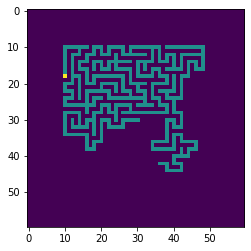

In [125]:
with open("p15_input.txt","r") as f:
    code = [int(c) for c in f.readline().strip().split(",")]
droid = RepairDroid(code)
print("Part 1 answer: {}".format(droid.find_oxygen()))
print("Maze Board")
plt.imshow(droid.board[:,:,0])
plt.show()

248


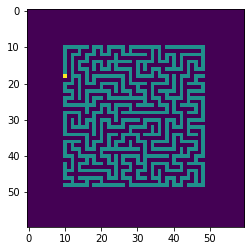

In [128]:
with open("p15_input.txt","r") as f:
    code = [int(c) for c in f.readline().strip().split(",")]
droid = RepairDroid(code)
print(droid.complete_search())
plt.imshow(droid.board[:,:,0])
plt.show()

Part 2 answer: 382
Maze distance to oxygen


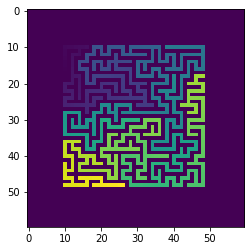

In [142]:
# now do BFS on the maze to find max depth from the oxygen
maze = droid.board[:,:,0]
ox = np.unravel_index(maze.argmax(),maze.shape)
prev = None
bfs_data = np.zeros((maze.shape[0],maze.shape[1],2),dtype=np.int)
bfs_data[ox[0],ox[1],1] = 1
to_visit = [(ox,prev)]
while len(to_visit) > 0:
    pos, prev = to_visit.pop()
    if prev is not None: # populate depth of current position
        bfs_data[pos[0],pos[1],0] = bfs_data[prev[0],prev[1],0] + 1
    # try the four neighbors
    next_pos = (pos[0]-1,pos[1])
    if maze[next_pos] > 0 and bfs_data[next_pos[0],next_pos[1],1] == 0:
        bfs_data[next_pos[0],next_pos[1],1] = 1
        to_visit.insert(0,(next_pos,pos))
    next_pos = (pos[0]+1,pos[1])
    if maze[next_pos] > 0 and bfs_data[next_pos[0],next_pos[1],1] == 0:
        bfs_data[next_pos[0],next_pos[1],1] = 1
        to_visit.insert(0,(next_pos,pos))
    next_pos = (pos[0],pos[1]-1)
    if maze[next_pos] > 0 and bfs_data[next_pos[0],next_pos[1],1] == 0:
        bfs_data[next_pos[0],next_pos[1],1] = 1
        to_visit.insert(0,(next_pos,pos))
    next_pos = (pos[0],pos[1]+1)
    if maze[next_pos] > 0 and bfs_data[next_pos[0],next_pos[1],1] == 0:
        bfs_data[next_pos[0],next_pos[1],1] = 1
        to_visit.insert(0,(next_pos,pos))
print("Part 2 answer: {}".format(bfs_data[:,:,0].max()))
print("Maze distance to oxygen")
plt.imshow(bfs_data[:,:,0])
plt.show()

In [108]:
# create a gif of the exploration
import imageio
images = []
for i in range(1,99):
    images.append(imageio.imread("maze_images/{}.png".format(i)))
imageio.mimsave('maze_images/movie.gif', images)